# Experimentation and Results

Our experiments are divided into three main parts:
1. Implementation of offensive and defensive formation detection for UGP high-frequency GPS tracking data.
2. Computation of player stationarity within detected attacking and defending phases.
3. Analysis on StatsBomb event data to validate formation detection in sparse data scenarios. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import Delaunay
import ruptures as rpt
import sys

from statsbombpy import sb

try:
    import os
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.1"
    os.add_dll_directory(r"C:\Program Files\R\R-4.3.1\bin\x64")
    import rpy2.robjects as robjects
    from rpy2.robjects import numpy2ri
    from rpy2.robjects.packages import importr
    numpy2ri.activate()
    gSeg = importr("gSeg")
except ImportError:
    print("Error importing rpy2. Ensure R is installed if using gSeg.")

rng = np.random.default_rng(0)

import src.Preprocessing as prep
import src.FormCPD as FormCPD
import src.RoleCPD as RoleCPD

In [2]:
# Data
# We provide several UGP files in the 'data/ugp/' directory.
# Each file corresponds to a different match.
# The '17985.ugp' file is from the K-League (South Korea), provided by Fitogether.
# The 7 digit files are from the A-League (Australia), provided by SkillCorner.
# The 'Real_vs_Barcelona_Calma.ugp' file is provided by Last Row, as part of the Friends of Tracking initiative. Note that it only contains one play and not a full match.
fitogether = prep.FitogetherDiagnosis(data_path='data/ugp/1925299.ugp')
gps_data = fitogether.load_or_generate_data()

Loading data from data/ugp/1925299.ugp.
Format: Metric (Centered). No transformation needed.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -15.41 to 23.57
Orientation is left to right. No changes made.


# 1. Offensive and Defensive Formation Change Point Detection (FormCPD)

We first define a helper function to stitch player trajectories into fixed slots, handling substitutions.

In [3]:
def get_stitched_tensor(df, n_slots=10):
    """
    Stitches disjoint player trajectories into 'n_slots' continuous tracks.
    This handles substitutions (e.g. Player A off, Player B on -> Slot 1).
    """
    # Identify temporal range for each player
    player_ranges = []
    for pid, group in df.groupby('player_id'):
        start = group['frame'].min()
        end = group['frame'].max()
        duration = len(group)
        player_ranges.append({
            'player_id': pid,
            'start': start,
            'end': end,
            'duration': duration,
            'data': group.set_index('frame')[['x', 'y']]
        })
    
    # Sort players by duration (longest playing time first) to identify core players
    player_ranges.sort(key=lambda x: x['duration'], reverse=True)
    
    # Assign players to slots
    # List of dicts: {'end_frame': int, 'data': series}
    slots = []
    
    for p in player_ranges:
        assigned = False
        # Try to fit into an existing slot (substitution)
        for s in slots:
            # Check if this player starts after the slot ends (plus a small buffer)
            if p['start'] > s['end_frame'] + 10: # 10 frames buffer
                s['parts'].append(p)
                s['end_frame'] = max(s['end_frame'], p['end'])
                assigned = True
                print(f"Stitched Player {p['player_id']} into Slot {s['id']}")
                break
        
        # If not assigned, create a new slot
        if not assigned:
            slots.append({
                'id': len(slots),
                'end_frame': p['end'],
                'parts': [p]
            })
            
    # Filter to top N slots
    if len(slots) > n_slots:
        print(f"Found {len(slots)} distinct tracks. Keeping top {n_slots} by duration.")
        for s in slots:
            s['total_duration'] = sum(p['duration'] for p in s['parts'])
        slots.sort(key=lambda x: x['total_duration'], reverse=True)
        slots = slots[:n_slots]
        
    # Construct the Tensor
    frames = sorted(df['frame'].unique())
    n_frames = len(frames)
    frame_map = {f: i for i, f in enumerate(frames)}
    
    X_tensor = np.full((n_frames, n_slots, 2), np.nan)
    
    for i, s in enumerate(slots):
        for part in s['parts']:
            indices = [frame_map[f] for f in part['data'].index if f in frame_map]
            X_tensor[indices, i, :] = part['data'].loc[list(part['data'].index)].values
            
    return X_tensor

In [4]:
# Stitching
print("Stitching trajectories to handle substitutions")
X_full = get_stitched_tensor(gps_data, n_slots=10)
# New shape should be (T x 10 x 2)
print(f"New Tensor Shape: {X_full.shape}.")

Stitching trajectories to handle substitutions
Stitched Player 560988 into Slot 19
Stitched Player 795533 into Slot 20
Stitched Player 966115 into Slot 21
Stitched Player 51722 into Slot 15
Stitched Player 795541 into Slot 16
Stitched Player 965698 into Slot 17
Stitched Player 809869 into Slot 14
Stitched Player 333110 into Slot 13
Stitched Player 966113 into Slot 12
Found 23 distinct tracks. Keeping top 10 by duration.
New Tensor Shape: (47942, 10, 2).


In [5]:
# Imputation
if np.isnan(X_full).any():
    print(f"Found {np.isnan(X_full).sum()} NaN values in trajectory data. Imputing...")
    for p in range(X_full.shape[1]):
        for dim in range(2):
            series = pd.Series(X_full[:, p, dim])
            series = series.interpolate(method='linear', limit_direction='both')
            series = series.fillna(method='bfill').fillna(method='ffill')
            X_full[:, p, dim] = series.values

    # Safety check for empty tracks
    if np.isnan(X_full).any():
        print("Warning: Replacing remaining NaNs with 0.")
        X_full = np.nan_to_num(X_full, nan=0.0)

In [6]:
# Phase Classification
# Calculate Team Centroid (average X position) per frame
team_centroid_x = np.mean(X_full[:, :, 0], axis=1)

# Define thresholds for attack and defense
ATTACK_THRESH = 5.0
DEFENSE_THRESH = -5.0

idx_attack = np.where(team_centroid_x > ATTACK_THRESH)[0]
idx_defense = np.where(team_centroid_x < DEFENSE_THRESH)[0]

print(f"Identified {len(idx_attack)} attacking frames and {len(idx_defense)} defensive frames.")

Identified 20952 attacking frames and 16981 defensive frames.


In [7]:
# EM-Hungarian Role Assignment
mu_global, roles_global = FormCPD.em_hungarian(X_full, n_iter=10)

EM-Hungarian: 100%|██████████| 10/10 [02:39<00:00, 15.98s/it]


In [8]:
# Helper function to plot formations
def plot_formation(ax, mu, title, color):
    # Safety check: if data has NaNs or Infs, skip plotting to prevent crash
    if np.isnan(mu).any() or np.isinf(mu).any():
        ax.text(0, 0, "Invalid Data (NaN/Inf)", ha='center', color='red')
        ax.axis('off')
        return

    try:
        tri = Delaunay(mu)
        ax.triplot(mu[:, 0], mu[:, 1], tri.simplices, color='gray', linestyle=':', alpha=0.5)
        ax.scatter(mu[:, 0], mu[:, 1], s=200, c=color, edgecolors='black', zorder=5)
        for i, (x, y) in enumerate(mu):
            ax.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white', fontweight='bold')
    except Exception as e:
        ax.text(0, 0, "Plot Error", ha='center', color='red')
    
    # Pitch Layout
    pitch_length = 105
    pitch_width = 68
    ax.axvline(-pitch_length/2, color='k', lw=2)
    ax.axvline(pitch_length/2, color='k', lw=2)
    ax.axhline(-pitch_width/2, color='k', lw=2)
    ax.axhline(pitch_width/2, color='k', lw=2)
    ax.set_xlim(-(pitch_length/2 + 5), (pitch_length/2 + 5))
    ax.set_ylim(-(pitch_width/2 + 5), (pitch_width/2 + 5))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Width (m)")

In [9]:
# We also define a pure Python version of the formation change detection in case of R/gSeg issues.
def detect_formation_changes_python(adjacency_sequence, min_minutes=5, n_bkps=4):
    """
    Detects formation changes using the Kernel Change Point Detection (Python only).
    Replaces the unstable R/gSeg implementation.
    """
    # Flatten (T, 10, 10) matrices into (T, 100) vectors
    T_sub = adjacency_sequence.shape[0]
    data_flat = adjacency_sequence.reshape(T_sub, -1)
    
    # Calculate minimum segment size in frames (1Hz assumption)
    min_size = min_minutes * 60 
    
    # Use Binary Segmentation
    try:
        algo = rpt.Binseg(model="l2", min_size=min_size).fit(data_flat)
        change_points = algo.predict(n_bkps=n_bkps)
    except Exception as e:
        print(f"Warning: Segmentation failed - {e}.")
        change_points = [T_sub]

    # Format results like the original output
    bkps = sorted(list(set([0] + change_points + [T_sub])))
    
    # Create segments list [(start, end), (start, end)...]
    segments = []
    for i in range(len(bkps) - 1):
        segments.append((bkps[i], bkps[i+1]))
    internal_cps = [cp for cp in bkps if cp != 0 and cp != T_sub]
    
    return {
        'num_phases': len(segments),
        'change_points': internal_cps,
        'segments': segments
    }

In [10]:
sys.setrecursionlimit(100)

T = X_full.shape[0]

# Align positions based on roles
X_roles = np.zeros_like(X_full)
for t in range(T):
    current_roles = roles_global[t]
    player_indices = np.argsort(current_roles)
    X_roles[t] = X_full[t, player_indices]

# Build graphs
subsample_rate = 60 
X_sub = X_roles[::subsample_rate]
valid_frames = np.arange(0, T, subsample_rate)

A_sequence = []
for t in range(len(X_sub)):
    # Calculate adjacency matrix
    try:
        adj = FormCPD.delaunay_adjacency(X_sub[t])
        A_sequence.append(adj)
    except Exception as e:
        # Fallback
        A_sequence.append(np.zeros((10, 10)))

A_sequence = np.array(A_sequence)

# Detect Changes 
print("Running Detection")
try:
    results = FormCPD.detect_formation_changes(
        A_sequence, 
        fps=1,            
        alpha=0.01,       
        min_minutes=5,    
        min_dist=10.0     
    )
    print("Detection complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
except Exception as e:
    # We encountered a few errors during implementation
    print(f"Crash or error during detection: {e}")
    print("Using Python method instead.")
    results = detect_formation_changes_python(A_sequence, min_minutes=5, n_bkps=4)
    detected_frames = [valid_frames[cp] for cp in results['change_points'] if cp < len(valid_frames)]
    print(f"Detection Complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
    print(f"Change Points (approx Frame IDs): {detected_frames}")

Running Detection
Original edge-count scan statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.64376 
  Approximated p-value: 5.63945e-42 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 15.66437 
  Approximated p-value: 1.024113e-26 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.65052 
  Approximated p-value: 1.323862e-23 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 15.62456 
  Approximated p-value: 2.857687e-25 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 215.5471 
  Approximated p-value: 5.405344e-45 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 250.2208 
  Approximated p-value: 1.729159e-52 
Max-type edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.65052 
  Ap

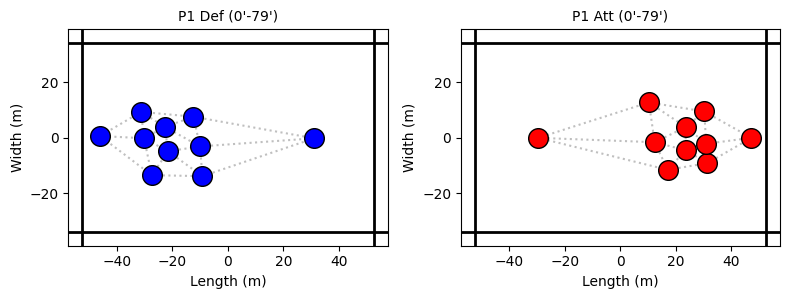

In [11]:
# Visualization of Detected Phases
n_phases = results['num_phases']
segments = results['segments']

# We limit the number of phases to plot for clarity (and to prevent OOM crashes)
MAX_PHASES_TO_PLOT = 10
if n_phases > MAX_PHASES_TO_PLOT:
    print(f"Warning: Too many phases detected ({n_phases}). Plotting first {MAX_PHASES_TO_PLOT} only.")
    n_plot = MAX_PHASES_TO_PLOT
else:
    n_plot = n_phases

# Create boolean masks 
is_attack = np.zeros(T, dtype=bool)
if 'idx_attack' in locals(): is_attack[idx_attack] = True

is_defense = np.zeros(T, dtype=bool)
if 'idx_defense' in locals(): is_defense[idx_defense] = True

# Create Figure
fig, axes = plt.subplots(n_plot, 2, figsize=(8, 4 * n_plot))
if n_plot == 1: axes = axes[:, np.newaxis]

for i in range(n_plot):
    start_sub, end_sub = segments[i]
    f_start = valid_frames[start_sub]
    f_end = valid_frames[min(end_sub, len(valid_frames)-1)]
    
    phase_data = X_roles[f_start:f_end]
    mask_att = is_attack[f_start:f_end]
    mask_def = is_defense[f_start:f_end]
    
    # Defense
    if np.any(mask_def):
        mu_def = np.nanmean(phase_data[mask_def], axis=0)
        plot_formation(axes[0, i], mu_def, f"P{i+1} Def ({f_start//600}'-{f_end//600}')", 'blue')
    else:
        axes[0, i].text(0,0, "No Data", ha='center')
        axes[0, i].axis('off')
        
    # Attack
    if np.any(mask_att):
        mu_att = np.nanmean(phase_data[mask_att], axis=0)
        plot_formation(axes[1, i], mu_att, f"P{i+1} Att ({f_start//600}'-{f_end//600}')", 'red')
    else:
        axes[1, i].text(0,0, "No Data", ha='center')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

The figure above illustrates the result of formation change point detection for offensive and defensive phases. We clearly see distinct formations during attack and defense.

# 2. Player Stationarity Analysis

In order to quantify how fixed or roaming players are during different formation phases, we compute the spatial standard deviation (stationarity) of players for each formation phase, split by Attack and Defense.

In [12]:
def calculate_player_stationarity(X_tensor, segments, attack_indices, defense_indices):
    """
    Calculates the spatial standard deviation (stationarity) of players for each formation phase, split by Attack and Defense.
    
    Lower Std Dev = Higher Stationarity (Fixed Position)
    Higher Std Dev = Lower Stationarity (Free Roaming)
    """
    stationarity_results = []

    for phase_id, (start, end) in enumerate(segments):
        # Define time range for this phase
        phase_frames = np.arange(start, end)
        
        # Intersect phase frames with Attack/Defense frames
        phase_att_idx = np.intersect1d(phase_frames, attack_indices)
        phase_def_idx = np.intersect1d(phase_frames, defense_indices)
        
        # Calculate metrics for Attack
        if len(phase_att_idx) > 10:
            pos_att = X_tensor[phase_att_idx] 
            means_att = np.nanmean(pos_att, axis=0)
            dists_att = np.linalg.norm(pos_att - means_att, axis=2)

            # Stationarity Metric: Standard Deviation of distances (Spread)
            std_att = np.nanstd(dists_att, axis=0)
        else:
            std_att = np.zeros(X_tensor.shape[1])

        # Calculate metrics for Defense
        if len(phase_def_idx) > 10:
            pos_def = X_tensor[phase_def_idx]
            means_def = np.nanmean(pos_def, axis=0)
            dists_def = np.linalg.norm(pos_def - means_def, axis=2)
            std_def = np.nanstd(dists_def, axis=0)
        else:
            std_def = np.zeros(X_tensor.shape[1])
            
        stationarity_results.append({
            'phase': phase_id,
            'attack_std': std_att,
            'defense_std': std_def
        })
        
    return stationarity_results

In [13]:
# Extract segments from detection results
det_segments_sub = results['segments']
det_segments_full = [(s*subsample_rate, e*subsample_rate) for s, e in det_segments_sub]

stat_metrics = calculate_player_stationarity(X_full, det_segments_full, idx_attack, idx_defense)

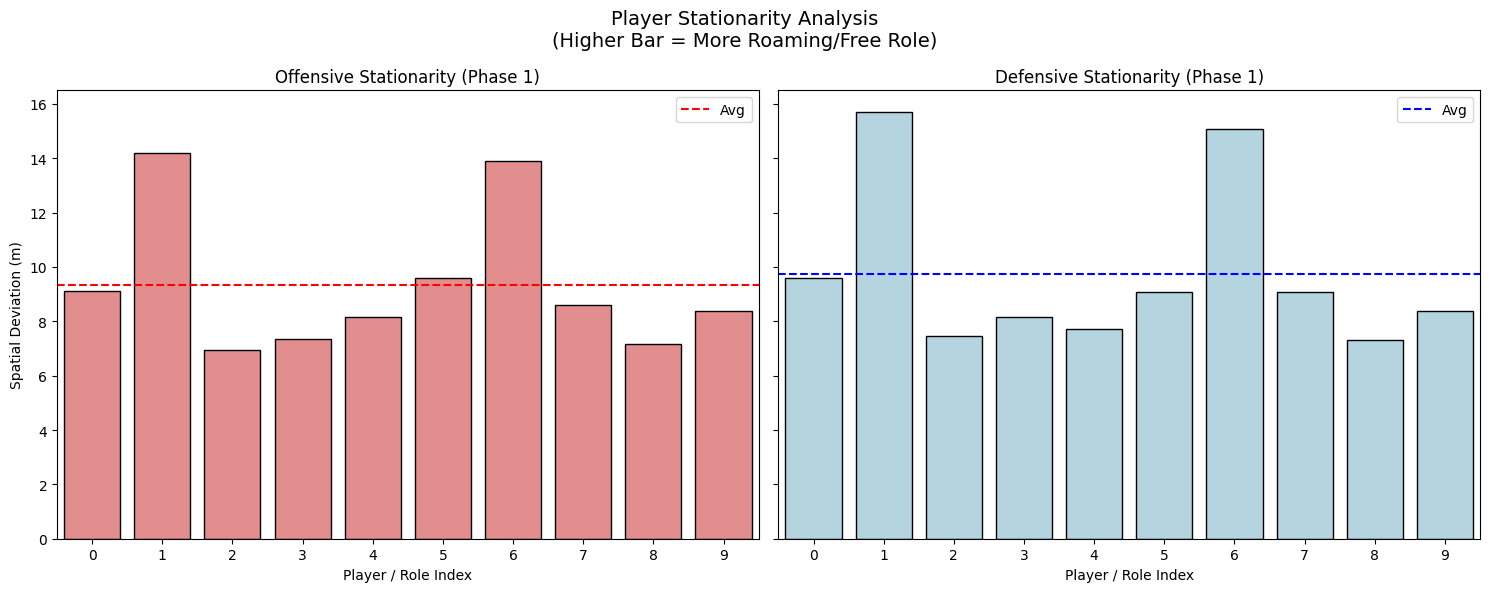

In [14]:
# Visualization of Stationarity Metrics
target_phase = 0 
data = stat_metrics[target_phase]

n_players = len(data['attack_std'])
player_ids = np.arange(n_players)

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Offensive Stationarity
sns.barplot(x=player_ids, y=data['attack_std'], ax=ax[0], color='lightcoral', edgecolor='black')
ax[0].set_title(f"Offensive Stationarity (Phase {target_phase+1})")
ax[0].set_xlabel("Player / Role Index")
ax[0].set_ylabel("Spatial Deviation (m)")
ax[0].axhline(np.mean(data['attack_std']), color='red', linestyle='--', label='Avg')
ax[0].legend()

# Defensive Stationarity
sns.barplot(x=player_ids, y=data['defense_std'], ax=ax[1], color='lightblue', edgecolor='black')
ax[1].set_title(f"Defensive Stationarity (Phase {target_phase+1})")
ax[1].set_xlabel("Player / Role Index")
ax[1].set_ylabel("Spatial Deviation (m)")
ax[1].axhline(np.mean(data['defense_std']), color='blue', linestyle='--', label='Avg')
ax[1].legend()

plt.suptitle("Player Stationarity Analysis\n(Higher Bar = More Roaming/Free Role)", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Identify the 'Roamer' (Max deviation in Attack)
roamer_idx = np.argmax(data['attack_std'])
print(f"Most active roamer in Attack: Player/Role {roamer_idx} ({data['attack_std'][roamer_idx]:.2f}m deviation)")

# Identify the 'Roamer' (Max deviation in Defense)
roamer_idx = np.argmax(data['defense_std'])
print(f"Most active roamer in Defense: Player/Role {roamer_idx} ({data['defense_std'][roamer_idx]:.2f}m deviation)")


Most active roamer in Attack: Player/Role 1 (14.20m deviation)
Most active roamer in Defense: Player/Role 1 (15.71m deviation)


As we can see from the bar plots above, players with lower spatial deviation (shorter bars) are more stationary, typically corresponding to fixed roles like center backs. In contrast, players with higher spatial deviation (taller bars) tend to roam more, often associated with free role playmakers, fullbacks, or wingers.

Moreover, depending on the team style, we can observe different stationarity patterns. For instance, teams that employ overlapping fullbacks or inverted wingers may show higher deviation for those roles during attacking phases. Furthermore, defensive stationarity patterns can reveal how tightly a team maintains its shape when out of possession.

# 3. StatsBomb Event Data

The use of StatsBomb event data, based on the lack of open-source high-frequency tracking datasets, allows us to validate our formation detection approach in sparse data scenarios. By applying our FormCPD method to event data, we can assess its effectiveness in identifying formation changes even with limited positional information. This demonstrates the versatility and robustness of the approach across different data types commonly used in football analytics.

We will choose Barcelona matches in La Liga from the most recent season available. In the implementation below, we use the first match of the season for demonstration purposes.

In [16]:
comps = sb.competitions()
la_liga = comps[(comps['country_name'] == 'Spain') & (comps['competition_name'] == 'La Liga')]
season = la_liga.sort_values('season_name', ascending=False).iloc[0]
print(f"Selected Season: {season['season_name']}")

# Get Matches
matches = sb.matches(competition_id=season['competition_id'], season_id=season['season_id'])
barca_matches = matches[(matches['home_team'] == 'Barcelona') | (matches['away_team'] == 'Barcelona')]

# Pick the first match
target_match = barca_matches.iloc[0]
match_id = target_match['match_id']
print(f"Selected Match: Barcelona vs {target_match['away_team'] if target_match['home_team']=='Barcelona' else target_match['home_team']} (ID: {match_id})")

# Load Events
events = sb.events(match_id=match_id)
print(f"Loaded {len(events)} events.")

Selected Season: 2020/2021
Selected Match: Barcelona vs Deportivo Alavés (ID: 3773386)
Loaded 3891 events.


In [17]:
# Preprocessing & Imputation
loc_events = events[events['location'].notna()].copy().reset_index(drop=True)
locs = np.vstack(loc_events['location'].values)

loc_events['sb_x'] = locs[:, 0]
loc_events['sb_y'] = locs[:, 1]

PITCH_LENGTH = 105.0
PITCH_WIDTH = 68.0
# Transform to Metric (Centered)
# X: 0..120 -> -52.5..52.5
loc_events['std_x'] = (loc_events['sb_x'] / 120.0 * PITCH_LENGTH) - (PITCH_LENGTH / 2)
# Y: 0..80 -> 34..-34
loc_events['std_y'] = (PITCH_WIDTH / 2) - (loc_events['sb_y'] / 80.0 * PITCH_WIDTH)
events = loc_events

# Create Continuous Time Grid
events['seconds'] = events['minute'] * 60 + events['second']

max_time = events['seconds'].max()
time_grid = np.arange(0, max_time + 1)

# Identify Top 10 Players
player_event_counts = events[events['team'] == 'Barcelona']['player'].value_counts()
top_10_players = player_event_counts.head(10).index.tolist()
print(f"Selected Top 10 Players: {top_10_players}")

# Build Trajectory Tensor X (Time x Players x 2)
X_barca = np.full((len(time_grid), len(top_10_players), 2), np.nan)

for i, player_name in enumerate(top_10_players):
    # Filter events for the player
    p_df = events[events['player'] == player_name]
    
    # Handle duplicate timestamps by averaging positions
    p_events_unique = p_df.groupby('seconds')[['std_x', 'std_y']].mean()
    
    # Reindex to the full time grid
    p_trace = p_events_unique.reindex(time_grid)
    
    # Forward Fill: Assume player stays in place until their next action
    p_trace = p_trace.ffill(limit=60) 
    
    # Fill remaining NaNs with Backward Fill
    p_trace = p_trace.bfill()
    p_trace = p_trace.fillna(0)
    
    X_barca[:, i, :] = p_trace.values

print(f"Constructed Imputed Trajectory Tensor: {X_barca.shape}")


Selected Top 10 Players: ['Frenkie de Jong', 'Gerard Piqué Bernabéu', 'Sergi Roberto Carnicer', 'Lionel Andrés Messi Cuccittini', 'Miralem Pjanić', 'Clément Lenglet', 'Anssumane Fati', 'Pedro González López', 'Jordi Alba Ramos', 'Sergio Busquets i Burgos']
Constructed Imputed Trajectory Tensor: (5694, 10, 2)


In [18]:
# EM-Hungarian
mu_barca, roles_barca = FormCPD.em_hungarian(X_barca, n_iter=10)

X_barca_metric = np.zeros_like(X_barca)
for t in range(len(X_barca)):
    X_barca_metric[t] = X_barca[t, roles_barca[t]]

# Build Adjacency Matrices
print("Building Adjacency Matrices")
A_barca_seq = []
valid_frames = np.arange(len(X_barca_metric))

for t in valid_frames:
    try:
        # Calculate Delaunay adjacency for the 10 players at time t
        adj = FormCPD.delaunay_adjacency(X_barca_metric[t])
        A_barca_seq.append(adj)
    except:
        A_barca_seq.append(np.zeros((10, 10)))

A_barca_seq = np.array(A_barca_seq)

# Detect Formation Changes
print("Detecting Formation Changes")
results_barca = FormCPD.detect_formation_changes(
    A_barca_seq,
    fps=1,            # Data is 1 frame per second
    alpha=0.05,       # Significance level
    min_minutes=5,    # Minimum phase duration (e.g., 5 mins)
    min_dist=5        # Minimum separation
)

print(f"Detected {results_barca['num_phases']} phases.")
print(f"Segments: {results_barca['segments']}")

EM-Hungarian: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Building Adjacency Matrices
Detecting Formation Changes
Original edge-count statistic (a): p-value approximation without skewness correction is reported.
Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (a): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (a): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 2866 
  Test statistic: 160.309 
  Approximated p-value: 0 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 2853 
  Test statistic: 305.3889 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 2866 
  T

In [19]:
# Define Possession Context (Attack vs Defense) ---
possession_map = events.groupby('seconds')['possession_team'].last().reindex(time_grid).ffill()
    
# Attack: When Barcelona has the ball
idx_att_barca = np.where(possession_map == 'Barcelona')[0]
# Defense: When Barcelona does NOT have the ball (Opponent or None)
idx_def_barca = np.where(possession_map != 'Barcelona')[0]

# Iterate Detected Phases & Compute Formations
segments = results_barca['segments']
n_phases = len(segments)

print(f"Detected {n_phases} Tactical Phases.")

Detected 2 Tactical Phases.


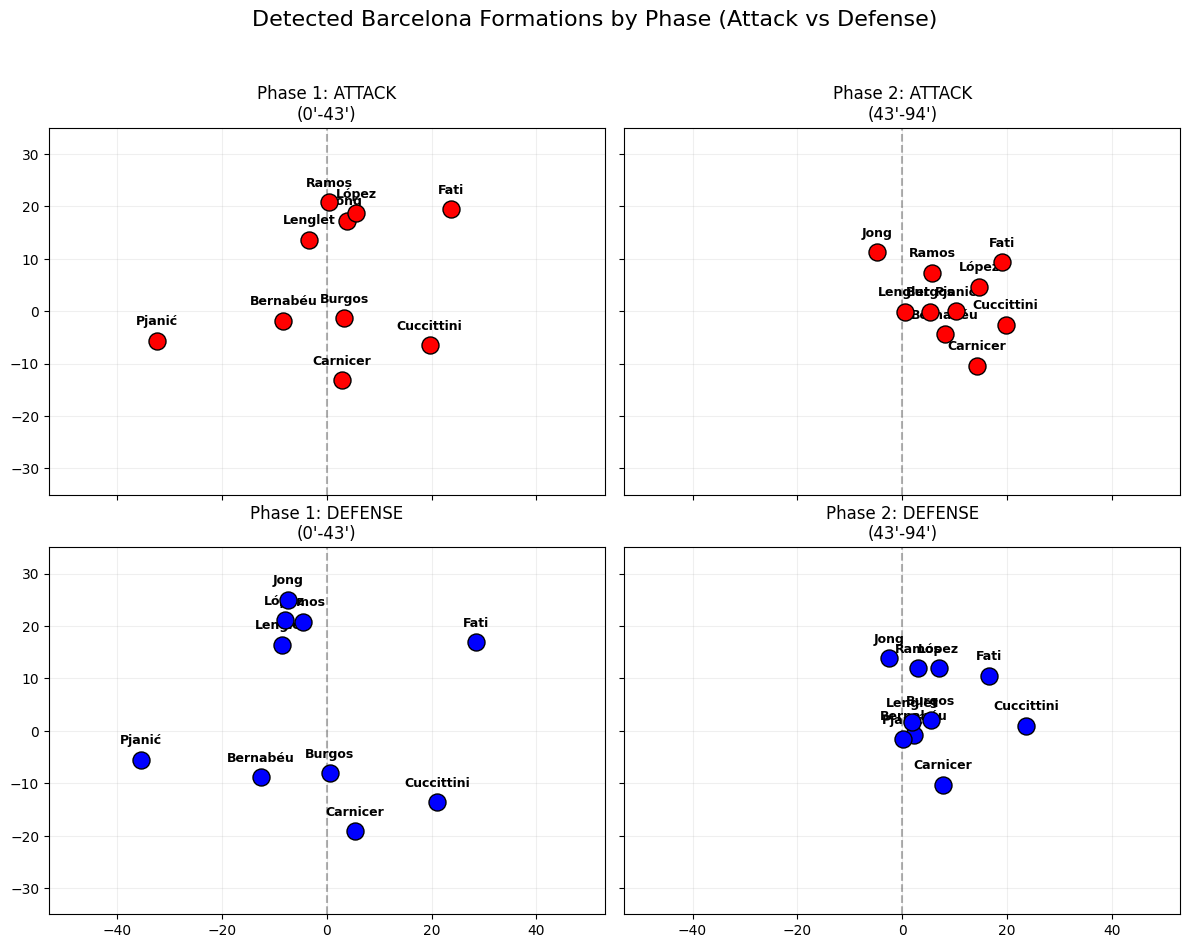

In [20]:
fig, axes = plt.subplots(2, n_phases, figsize=(6 * n_phases, 10), sharex=True, sharey=True)

if n_phases == 1:
    axes = axes[:, np.newaxis]

for i, (start, end) in enumerate(segments):
    # Indices for this specific segment
    phase_frames = np.arange(start, end)
    
    # Intersection: Segment Frames AND Attack/Defense State
    curr_att_idx = np.intersect1d(phase_frames, idx_att_barca)
    curr_def_idx = np.intersect1d(phase_frames, idx_def_barca)
    
    # Plot Attacking Formation
    ax_att = axes[0, i]
    if len(curr_att_idx) > 10:
        pos_att = X_barca_metric[curr_att_idx] 
        # Calculate Mean Position (Centroid) -> The "Formation"
        mu_att = np.nanmean(pos_att, axis=0)
        
        # Scatter Plot
        ax_att.scatter(mu_att[:, 0], mu_att[:, 1], c='red', s=150, edgecolors='k', zorder=5)
        
        # Annotate Players
        for p_idx, (px, py) in enumerate(mu_att):
            if not np.isnan(px):
                # Use last name for brevity
                name = top_10_players[p_idx].split()[-1] 
                ax_att.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
        
        ax_att.set_title(f"Phase {i+1}: ATTACK\n({start//60}'-{end//60}')")
    else:
        ax_att.text(0, 0, "Low/No Possession Data", ha='center')
        ax_att.set_title(f"Phase {i+1}: ATTACK")

    # Plot Defensive Formation
    ax_def = axes[1, i]
    if len(curr_def_idx) > 10:
        pos_def = X_barca_metric[curr_def_idx]
        mu_def = np.nanmean(pos_def, axis=0)
        
        ax_def.scatter(mu_def[:, 0], mu_def[:, 1], c='blue', s=150, edgecolors='k', zorder=5)
        
        for p_idx, (px, py) in enumerate(mu_def):
            if not np.isnan(px):
                name = top_10_players[p_idx].split()[-1]
                ax_def.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
                
        ax_def.set_title(f"Phase {i+1}: DEFENSE\n({start//60}'-{end//60}')")
    else:
        ax_def.text(0, 0, "Low/No Defense Data", ha='center')
        ax_def.set_title(f"Phase {i+1}: DEFENSE")

    # Add Pitch
    for ax in [ax_att, ax_def]:
        ax.set_xlim(-53, 53)
        ax.set_ylim(-35, 35)
        ax.axvline(0, c='k', alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

plt.suptitle("Detected Barcelona Formations by Phase (Attack vs Defense)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We successfully extracted the offensive and defensive formations for Barcelona using the StatsBomb event data. The detected formations for attack and defense clearly illustrate the team's tactical setup during different phases of play, showcasing the effectiveness of our formation detection approach even with sparse event data.

In [21]:
# Player Stationarity Analysis
stat_metrics_barca = calculate_player_stationarity(
    X_barca_metric,             # Role-aligned trajectory tensor
    results_barca['segments'],  # Detected formation phases
    idx_att_barca,              # Attack frames (Possession)
    idx_def_barca               # Defense frames (No Possession)
)

In [22]:
def plot_stationarity_barca(metrics, phase_idx, player_names=None):
    if phase_idx >= len(metrics):
        print(f"Phase {phase_idx+1} not found.")
        return

    data = metrics[phase_idx]
    n_roles = len(data['attack_std'])
    role_ids = np.arange(n_roles)

    # Create Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # 1. Attack Stationarity
    sns.barplot(x=role_ids, y=data['attack_std'], ax=ax[0], color='firebrick', edgecolor='black')
    ax[0].set_title(f"ATTACK Stationarity (Phase {phase_idx+1})\n(Barcelona Possession)")
    ax[0].set_xlabel("Tactical Role ID")
    ax[0].set_ylabel("Spatial Deviation (meters)")
    
    # Add average line
    avg_att = np.nanmean(data['attack_std'])
    ax[0].axhline(avg_att, color='red', linestyle='--', label=f'Avg: {avg_att:.1f}m')
    ax[0].legend()

    # 2. Defense Stationarity
    sns.barplot(x=role_ids, y=data['defense_std'], ax=ax[1], color='royalblue', edgecolor='black')
    ax[1].set_title(f"DEFENSE Stationarity (Phase {phase_idx+1})\n(Opponent Possession)")
    ax[1].set_xlabel("Tactical Role ID")
    
    # Add average line
    avg_def = np.nanmean(data['defense_std'])
    ax[1].axhline(avg_def, color='blue', linestyle='--', label=f'Avg: {avg_def:.1f}m')
    ax[1].legend()

    # Annotations
    plt.suptitle(f"Barcelona Role Stationarity: Phase {phase_idx+1}\n(Higher Bar = More Roaming / Free Role)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print numerical summary
    print(f"--- Phase {phase_idx+1} Summary ---")
    print(f"Avg Attack Deviation: {avg_att:.2f}m")
    print(f"Avg Defense Deviation: {avg_def:.2f}m")
    
    # Identify most fluid role
    most_fluid_att = np.nanargmax(data['attack_std'])
    print(f"Most Fluid Attacking Role: Role {most_fluid_att} (std: {data['attack_std'][most_fluid_att]:.2f}m)")

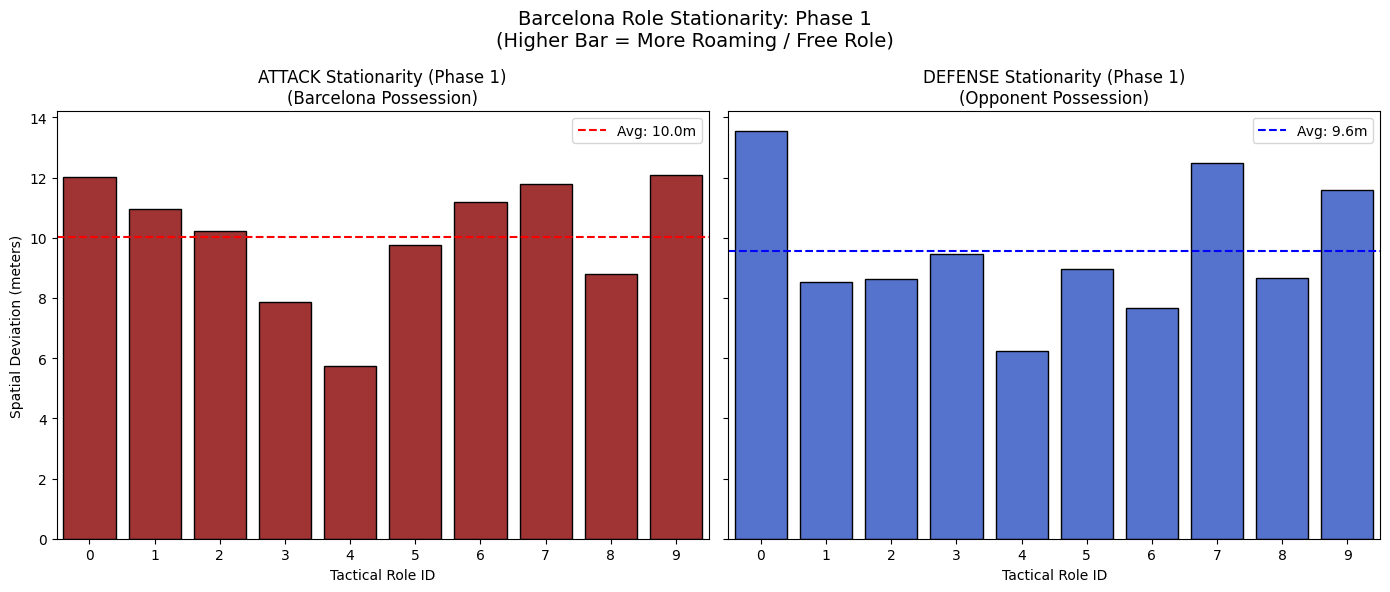

--- Phase 1 Summary ---
Avg Attack Deviation: 10.04m
Avg Defense Deviation: 9.57m
Most Fluid Attacking Role: Role 9 (std: 12.10m)


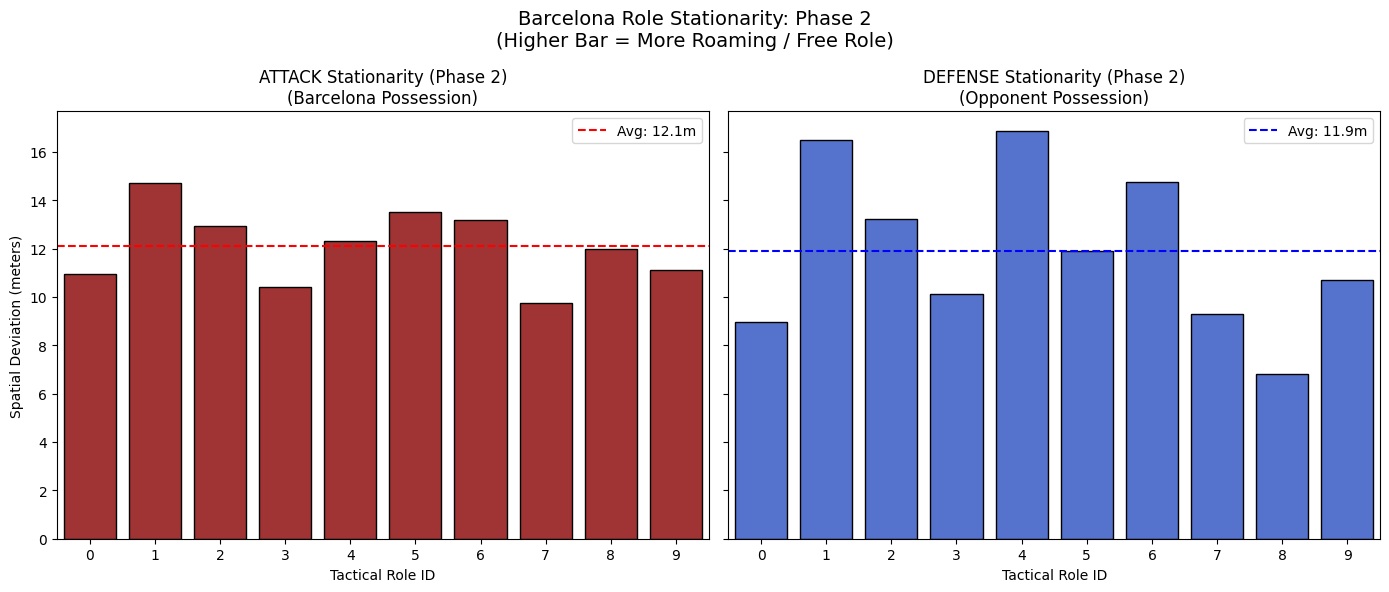

--- Phase 2 Summary ---
Avg Attack Deviation: 12.08m
Avg Defense Deviation: 11.90m
Most Fluid Attacking Role: Role 1 (std: 14.70m)


In [23]:
plot_stationarity_barca(stat_metrics_barca, phase_idx=0)

# If a second phase exists (e.g. after a substitution or tactical switch), plot that too
if len(stat_metrics_barca) > 1:
    plot_stationarity_barca(stat_metrics_barca, phase_idx=1)

We also perform player stationarity analysis on the detected formation phases from the StatsBomb data. The resulting stationarity metrics provide insights into how fixed or roaming players are during different phases of play, similar to our analysis with high-frequency tracking data. This further validates the applicability of our methods across different data sources in football analytics, though the sparse nature of event data may limit the granularity of insights compared to high-frequency tracking data.